In [7]:
import torch

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
print(device)

cuda


In [53]:
import numpy as np
from sample_data.mnist import load_mnist
from two_layer_net import TwoLayerNet # 저장해놨음

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 하이퍼 파라미터
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0] # 60000개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # loss fun -> return grads
    grad = network.gradient(x_batch, t_batch) # 성능 개선판!

    # 매개변수 갱신 (하강법)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

In [54]:
print(max(train_loss_list))

2.3015899817474073


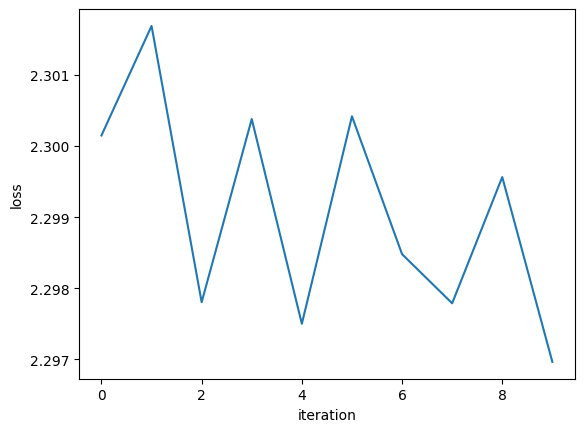

In [35]:
x = np.arange(len(train_loss_list)) # 100회 original.ver
plt.plot(x, train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

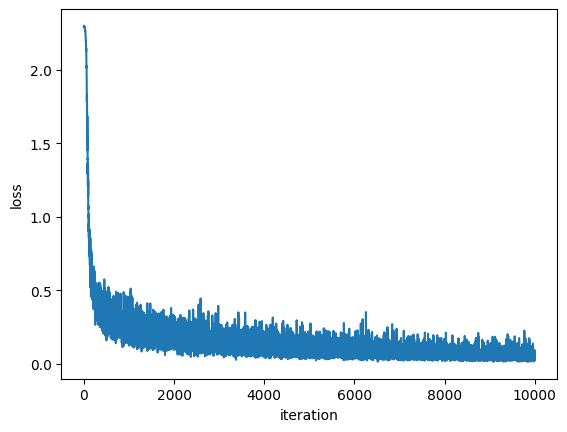

In [24]:
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_list)) # ~iters_num
plt.plot(x, train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

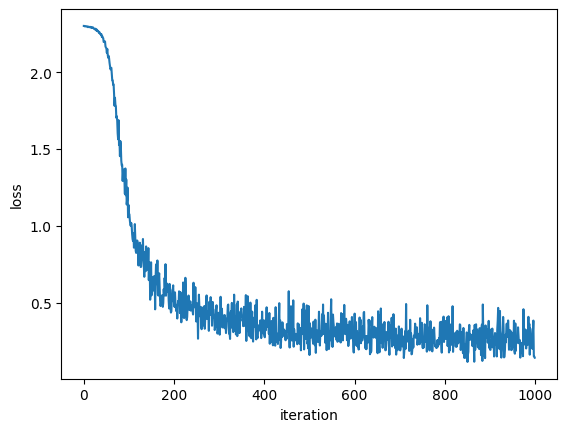

In [23]:
x = np.arange(1000)
plt.plot(x, train_loss_list[:1000])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [27]:
a = np.array([1, 2, 3])

In [30]:
len(a)

3

In [32]:
a[:3]

array([1, 2, 3])

In [58]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.pardir)
from common.functions import * # 모든 함수 불러옴
from common.gradient import numerical_gradient

class TwoLayerNet:
    # 초기화 메서드
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01): #가중치 초기화 시 표준편차를 지정하여 얼마나 랜덤하게 초기화할지
        # 가중치 초기화(후에 배움)
        self.params = {} # dictionary
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # 각 row
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0]) # 총 일치 개수 / 전체 데이터
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)  # loss_W(W): return ~.

        grads = {} # dictionary (기울기 보관)
        grads['W1'] = numerical_gradient(loss_W, self.params['W1']) # gradient of params
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

# 다음 장에서 배울 내용-----numerical 대신 오차역전파로 기울기 구하기-----
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0] # input data

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

print(max(train_loss_list))

2.3052267557049766


In [60]:
x = np.float(1 / 3)
print(x)

0.3333333333333333


<ipython-input-60-b8f6176e0cc1>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.float(1 / 3)


train acc, test acc | 0.08351666666666667, 0.0945
train acc, test acc | 0.9019666666666667, 0.9065
train acc, test acc | 0.9224833333333333, 0.9253
train acc, test acc | 0.9386833333333333, 0.9389
train acc, test acc | 0.9464666666666667, 0.9465
train acc, test acc | 0.9521833333333334, 0.9509
train acc, test acc | 0.9581666666666667, 0.9549
train acc, test acc | 0.9627666666666667, 0.9601
train acc, test acc | 0.9667166666666667, 0.9622
train acc, test acc | 0.96855, 0.9618
train acc, test acc | 0.9711166666666666, 0.966
train acc, test acc | 0.9729666666666666, 0.9668
train acc, test acc | 0.9749, 0.9685
train acc, test acc | 0.9759666666666666, 0.9698
train acc, test acc | 0.9762, 0.9682
train acc, test acc | 0.9790666666666666, 0.971
train acc, test acc | 0.9797, 0.9716


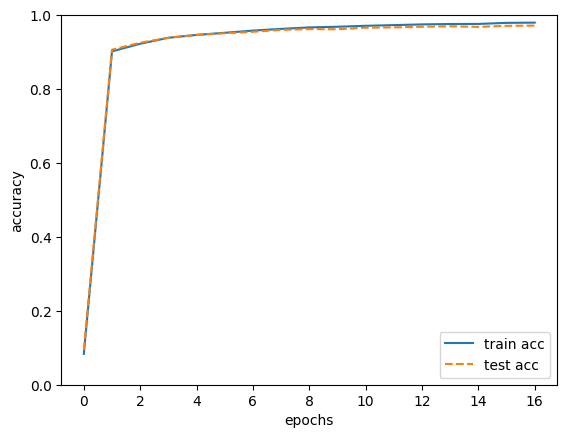

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sample_data.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list)) # 1에폭당
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [102]:
print(max(train_loss_list))

2.3021386980855


In [81]:
train_size = 100
batch_size = 10

batch_mask = np.random.choice(train_size, batch_size) # 0~99
print("랜덤으로 선택된 인덱스:", batch_mask) # numpy array

랜덤으로 선택된 인덱스: [72 61 95 51 86 57 60 95 95 12]


In [85]:
# 선택된 인덱스에 해당하는 데이터 추출
x_train = np.random.randn(train_size, 4) # col 4개만 임시로
x_batch = x_train[batch_mask]
print("미니배치 데이터:", x_batch)

미니배치 데이터: [[ 0.00453159 -0.54179614 -0.87639072  0.47788443]
 [ 0.12345588 -0.27023954  2.66842208  0.58887517]
 [-0.29546488  2.57017819 -1.29746276  0.31271139]
 [ 0.97925156  0.93080739  0.82677111 -2.17192436]
 [ 0.20297852  0.69777683  1.35387266 -0.80467964]
 [-1.06675637 -0.86911362  0.38984341  0.0676065 ]
 [ 0.54932721  1.49637364  0.07503164  0.66990479]
 [-0.29546488  2.57017819 -1.29746276  0.31271139]
 [-0.29546488  2.57017819 -1.29746276  0.31271139]
 [-0.38670149  0.13491651  0.35895322 -0.80575873]]


In [86]:
x_train[72]

array([ 0.00453159, -0.54179614, -0.87639072,  0.47788443])

train acc, test acc | 0.14543333333333333, 0.1463
train acc, test acc | 0.9062333333333333, 0.911
train acc, test acc | 0.92465, 0.9265
train acc, test acc | 0.93645, 0.9364
train acc, test acc | 0.9449833333333333, 0.9433
train acc, test acc | 0.9513166666666667, 0.9501
train acc, test acc | 0.9570666666666666, 0.9536
train acc, test acc | 0.9594833333333334, 0.9557
train acc, test acc | 0.9632166666666667, 0.9599
train acc, test acc | 0.9663166666666667, 0.9618
train acc, test acc | 0.9680833333333333, 0.963
train acc, test acc | 0.9695, 0.9628
train acc, test acc | 0.9720333333333333, 0.9647
train acc, test acc | 0.9739333333333333, 0.9665
train acc, test acc | 0.9755, 0.9679
train acc, test acc | 0.9756833333333333, 0.9682
train acc, test acc | 0.9779666666666667, 0.9702


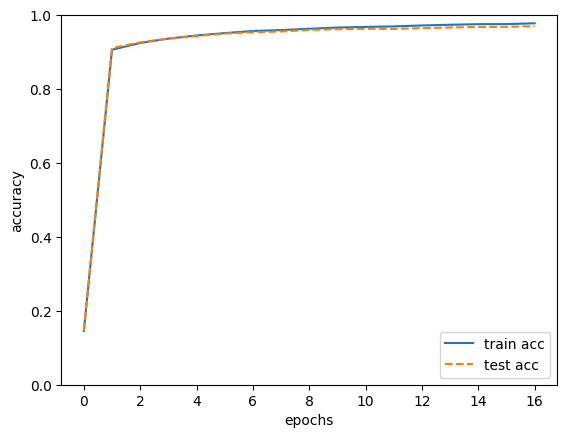

In [104]:
import numpy as np
from sample_data.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # loss -> return grads, grads dictionary-key는 params
    grad = network.gradient(x_batch, t_batch) # 성능 개선판!

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | "
              + str(train_acc) + ", " + str(test_acc))

import matplotlib.pyplot as plt

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list)) # acc - 1에폭당
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right') # label location
plt.show()

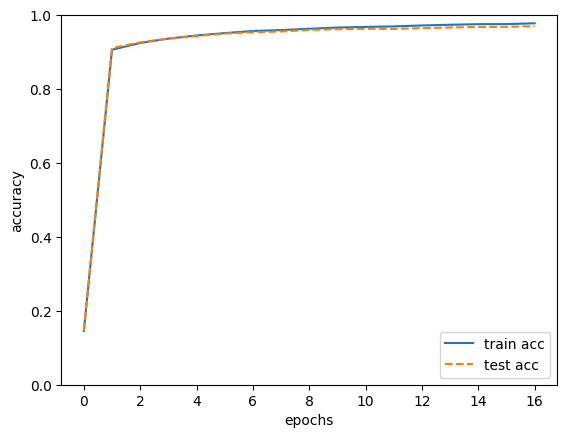

In [106]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list)) # acc - 1에폭당
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right') # label location
plt.show()

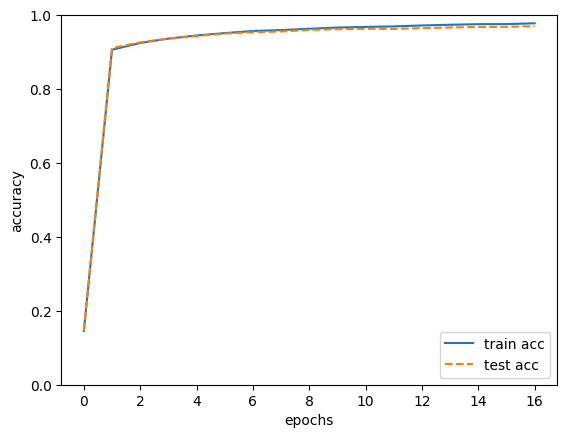

In [109]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list)) # acc - 1에폭당
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right') # label location
plt.show()

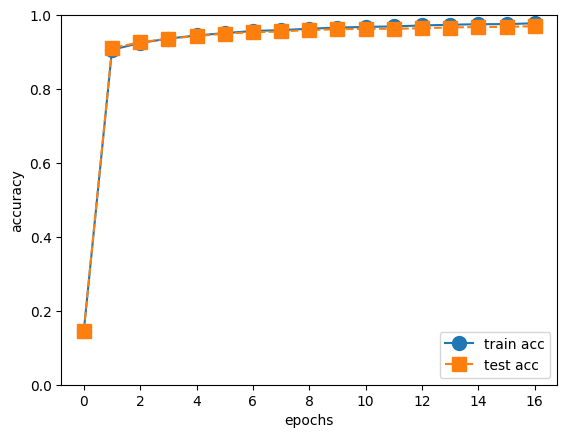

In [110]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list)) # acc - 1에폭당
plt.plot(x, train_acc_list, label='train acc', marker=markers['train'], markersize=10)
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker=markers['test'], markersize=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right') # label location
plt.show()

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_list)) # ~iters_num
plt.plot(x, train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()